# Long-lenght legal documents classification for spanish corpora

In this notebook we'll classify long length legal documents: *court ruling*. The corpus was generated by a sample of Supreme Court of Buenos Aires (Argentina) on line data base. The goal of the task is to predict the judicial branch -a categorical variable in our dataset- through training a supervised statistical model. So, we'll first clean de data withe same NLP technics, then we'll vectorize the document with *doc2vec* and finally classify them. In order to judge the performance of the model we'll evaluate the results.

Referencias consultadas

- [Gensim](https://radimrehurek.com/gensim/index.html).  
- Github notebooks: [1](https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint_3.ipynb), [2](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb), [3](https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb), [4](https://github.com/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb), [5](https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d), [6](https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb)


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
f = open('data/corpus_textosfallos.json', encoding="utf8")
d = open('data/corpus_fallosmetdat.json', encoding="utf8")
fallos = json.load(f)
fdatos = json.load(d)

We are going to work with two data frames. The *fdatos* stores the judicial metada of each legal case of aour sample and the target variable call ***materia***. The othe data frame *fallos* stores the court's rulings, also refered as 'sentences' or 'judgment'. Both data frames are map with an index. 

First lets have a look of the metada.

/home/sebacastillo/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   indice                4299 non-null   int64 
 1   textos_raw_len        4299 non-null   int64 
 2   materia               4298 non-null   object
 3   fecha                 4298 non-null   object
 4   tipo_fallo            4298 non-null   object
 5   tribunal_emisor       4298 non-null   object
 6   id_causa              4298 non-null   object
 7   fecha_res             4298 non-null   object
 8   nro_reg_int           4298 non-null   object
 9   caratula              4298 non-null   object
 10  caratula_pub          4298 non-null   object
 11  magistrados_votantes  4298 non-null   object
 12  tribunal_origen       4298 non-null   object
 13  nnf                   4298 non-null   object
 14  observ                4298 non-null   object
 15  sent_anulada          4298 non-null   

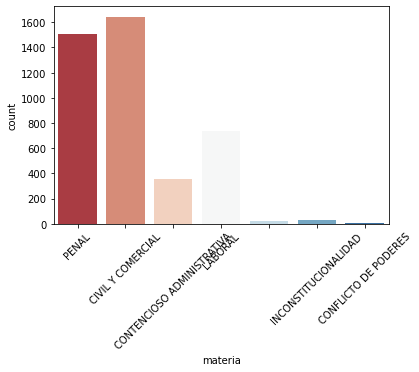

In [15]:
df = pd.DataFrame(fdatos)
chart = sns.countplot(df['materia'], palette='RdBu')
print(df.info())
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);


As we can see, the documents are classify in branches associated with the subject of the legal claim. The cases aren't equally distributed through the branches (they are imbalanced), so we will keep those who have more observation and drop the others. 

In [9]:
print(df['materia'].value_counts())
print(df['tipo_fallo'].value_counts())

CIVIL Y COMERCIAL             1645
PENAL                         1507
LABORAL                        738
CONTENCIOSO ADMINISTRATIVA     354
INCONSTITUCIONALIDAD            28
                                24
CONFLICTO DE PODERES             2
Name: materia, dtype: int64
Sentencia Interlocutoria    2342
Sentencia Definitiva        1931
                              24
Plenario                       1
Name: tipo_fallo, dtype: int64


We will subset our data in order to focus in these branches: 'CIVIL Y COMERCIAL','PENAL','LABORAL', and these clases of legal sentences: "Sentencia Interlocutoria", 'Sentencia Definitiva'.

In [11]:

materias_elegidas = ['CIVIL Y COMERCIAL','PENAL','LABORAL']
tipo_felegidos = ["Sentencia Interlocutoria", 'Sentencia Definitiva']
dfxmat = df[df['materia'].notna()]
dfxmat = df[df['materia'].isin(materias_elegidas)]
dfxtfallo = df[df['tipo_fallo'].notna()]
dfxtfallo = df[df['tipo_fallo'].isin(tipo_felegidos)]
# subset data
print(dfxmat['materia'].value_counts())
print(dfxtfallo['tipo_fallo'].value_counts())

CIVIL Y COMERCIAL    1645
PENAL                1507
LABORAL               738
Name: materia, dtype: int64
Sentencia Interlocutoria    2342
Sentencia Definitiva        1931
Name: tipo_fallo, dtype: int64


In [22]:
dfxmat.shape

(3890, 21)

Now, we are going to subset the sentences data frame by index in our *dfxmat* data frame. 

In [18]:
dfallos = pd.DataFrame(fallos)
dfallos = dfallos[dfallos.indice.isin(dfxmat.indice)]

In [23]:
dfallos.shape

(3890, 2)

In [25]:
dfallos.head()

,indice,textos_fallo
0,1,#TEXTO COMPLETO#A C U E R D O#En la ciudad de ...
1,2,#TEXTO COMPLETO#A C U E R D O#En la ciudad de ...
2,3,#TEXTO COMPLETO#REGISTRO N° 291-S ...
3,4,#TEXTO COMPLETO#NO DISPONE DE TEXTO PARA MOSTRAR
4,5,#TEXTO COMPLETO#A C U E R D O#En la ciudad de ...


Lets check if we have the same cases in both data frames

In [24]:
dfallos['indice'].equals(dfxmat['indice'])

True

Now, let's begin cleaning our corpus

In [33]:
dfallos.iloc[1,1]

'#TEXTO COMPLETO#A C U E R D O#En la ciudad de La Plata, a 14 de diciembre de 2016, habiéndose establecido, de conformidad con lo dispuesto en el Acuerdo 2078, que deberá observarse el siguiente orden de votación: doctores Pettigiani, de Lázzari, Kogan, Negri, se reúnen los señores jueces de la Suprema Corte de Justicia en acuerdo ordinario para pronunciar sentencia definitiva en la causa P. 125.638, "Medina, Héctor Ramón. Recurso extraordinario de inaplicabilidad de ley en causa N° 64.717 del Tribunal de Casación Penal, Sala II".#A N T E C E D E N T E S#La Sala Segunda del Tribunal de Casación Penal, mediante el pronunciamiento dictado el 27 de noviembre de 2014, rechazó -por improcedente- el recurso de la especialidad interpuesto por la defensa oficial contra la sentencia del Tribunal en lo Criminal Nº 1 del Departamento Judicial San Martín que condenó a Héctor Ramón Medina a la pena de dieciséis años de prisión, accesorias legales y costas, como coautor penalmente responsable del de

In [37]:
dfallos['textos_fallo'].apply(lambda x: len(x.split(' '))).sum()

6294389

We have a 6 million words.

In [61]:
df_indice_mat = dfxmat[['indice', 'materia']]

In [62]:
dfallos = pd.merge(dfallos, df_indice_mat, how='left', on='indice')

In [63]:
def print_fallo(index):
    example = dfallos[dfallos.index == index][['textos_fallo', 'materia']].values[0]
    if len(example) > 0:
        print(example[0])
        print('indice:', example[1])

In [64]:
print_fallo(1)

 teto completo a c u e r d o en la ciudad de la plata, a 14 de diciembre de 2016, habiéndose establecido, de conformidad con lo dispuesto en el acuerdo 2078, que deberá observarse el siguiente orden de votación: doctores pettigiani, de lázzari, kogan, negri, se reúnen los señores jueces de la suprema corte de justicia en acuerdo ordinario para pronunciar sentencia definitiva en la causa p. 125.638, "medina, héctor ramón. recurso etraordinario de inaplicabilidad de ley en causa n° 64.717 del tribunal de casación penal, sala ii". a n t e c e d e n t e s la sala segunda del tribunal de casación penal, mediante el pronunciamiento dictado el 27 de noviembre de 2014, rechazó -por improcedente- el recurso de la especialidad interpuesto por la defensa oficial contra la sentencia del tribunal en lo criminal nº 1 del departamento judicial san martín que condenó a héctor ramón medina a la pena de dieciséis años de prisión, accesorias legales y costas, como coautor penalmente responsable del delit

Simple text pre-processing

In [43]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = text.replace('#', ' ')
    return text
dfallos['textos_fallo'] = dfallos['textos_fallo'].apply(cleanText)

In [44]:
print_fallo(1)

 teto completo a c u e r d o en la ciudad de la plata, a 14 de diciembre de 2016, habiéndose establecido, de conformidad con lo dispuesto en el acuerdo 2078, que deberá observarse el siguiente orden de votación: doctores pettigiani, de lázzari, kogan, negri, se reúnen los señores jueces de la suprema corte de justicia en acuerdo ordinario para pronunciar sentencia definitiva en la causa p. 125.638, "medina, héctor ramón. recurso etraordinario de inaplicabilidad de ley en causa n° 64.717 del tribunal de casación penal, sala ii". a n t e c e d e n t e s la sala segunda del tribunal de casación penal, mediante el pronunciamiento dictado el 27 de noviembre de 2014, rechazó -por improcedente- el recurso de la especialidad interpuesto por la defensa oficial contra la sentencia del tribunal en lo criminal nº 1 del departamento judicial san martín que condenó a héctor ramón medina a la pena de dieciséis años de prisión, accesorias legales y costas, como coautor penalmente responsable del delit

In [ ]:
#import spacy.cli
#spacy.cli.download("es_core_news_md")
#from spacy.lang.es.stop_words import STOP_WORDS

In [66]:
train, test = train_test_split(dfallos, test_size=0.3, random_state=42)

In [57]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /home/sebacastillo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [67]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['textos_fallo']), tags=[r.materia]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['textos_fallo']), tags=[r.materia]), axis=1)

In [68]:
train_tagged.values[1]

TaggedDocument(words=['teto', 'completo', 'teto', 'completo', 'privado'], tags=['CIVIL Y COMERCIAL'])

In [71]:
train_tagged.shape

(2723,)

In [72]:
test_tagged.shape

(1167,)

Finally, let's train our model

In [73]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [74]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 2723/2723 [00:00<00:00, 2476385.47it/s]


In [75]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|██████████| 2723/2723 [00:00<00:00, 2503526.92it/s]


CPU times: user 6min 33s, sys: 2.31 s, total: 6min 35s
Wall time: 1min 57s


In [77]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)



/home/sebacastillo/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6932305055698372
Testing F1 score: 0.6912035359973596
